In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# default_exp core

# core
> Defines the methods required for productionizing the face profile.  Must include Deployment class (for ubiops)

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
%matplotlib inline

In [5]:
#export 
import io
import skimage
from skimage import color
from prcvd.img.core import (
    TrainedSegmentationModel, MaskedImg
)
from prcvd.img.face import (
    FacialProfile
)

/home/fortville/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Define the location of the deployment package

In [46]:
depdir = Path(os.getcwd()).parent / 'deployment_package'

## Write `requirements.txt`

In [49]:
import pandas as pd
REQUIREMENTS = [
    ['io', ''], 
    ['skimage', '=='+skimage.__version__], 
    ['prcvd', '']
]
reqfp = depdir / 'requirements.txt'
pd.DataFrame(
    [
        {'r': req[0]+req[1]} for req in REQUIREMENTS
    ]).to_csv(
    reqfp, index=False, header=False
)

In [6]:
#export
def get_y_fn(fp):
    l_str = str(img_to_l[fp])
    out = l_str \
        .replace('labels', 'labels_int') \
        .replace('png', 'tif')
    return out

## Write `Deployment` class

### Setup the `<prod library>.core` module
This module will be imported into the deployment package so that this process can be repeatable, and tied to my jupyter notebook code.  Below, we will define and test the code just like any other notebook. Then at the end, we will push that exact code to the UbiOps endpoint.  Then, in the future, the process can be repeated if the endpoint needs to be updated.  Test in jupyter, then push.

In [17]:
#export
class UbiDeployment:
    def __init__(self, base_directory, context):
        """
        Initialisation method for the deployment. It can for example be used for loading modules that have to be kept in
        memory or setting up connections. Load your external model files (such as pickles or .h5 files) here.
        :param str base_directory: absolute path to the directory where the deployment.py file is located
        :param dict context: a dictionary containing details of the deployment that might be useful in your code.
            It contains the following keys:
                - deployment (str): name of the deployment
                - version (str): name of the version
                - input_type (str): deployment input type, either 'structured' or 'plain'
                - output_type (str): deployment output type, either 'structured' or 'plain'
                - language (str): programming language the deployment is running
                - environment_variables (str): the custom environment variables configured for the deployment.
                    You can also access those as normal environment variables via os.environ
        """
        print("Loading face segmentation model.")
        self.mod_fp = base_directory/'checkpoint_20201007'
        self.output_classes = [
            'Background/undefined', 'Lips', 'Eyes', 'Nose', 'Hair', 
            'Ears', 'Eyebrows', 'Teeth', 'General face', 'Facial hair',
            'Specs/sunglasses'
        ]
        self.size = 224
        self.basedir = Path(base_directory)
        self.mod_fp = self.basedir/"checkpoint_20201007"
        self.model = TrainedSegmentationModel(
            mod_fp=self.mod_fp, 
            input_size=self.size,
            output_classes=self.output_classes
        )

    
    def request(self, data, attempt=1):
        """
        Method for deployment requests, called separately for each individual request.
        :param dict/str data: request input data. In case of deployments with structured data, a Python dictionary
            with as keys the input fields as defined upon deployment creation via the platform. In case of a deployment
            with plain input, it is a string.
                - img: list, data from image
                - sampling_strategy: str, 'use_all' | ...
                - align_face: bool, yes/no apply face alignment
                - num_attempts: int, max attempts before failure (sometimes face alignment fails)
                
        :return dict/str: request output. In case of deployments with structured output data, a Python dictionary
            with as keys the output fields as defined upon deployment creation via the platform. In case of a deployment
            with plain output, it is a string. In this example, a dictionary with the key: output.
        """
        img = MaskedImg()
        img.load_from_nparray(
            data['img']
        ) # possibly need to tx list -> np
        
        try:
            profile = FacialProfile(
                model=self.model, 
                img=img, 
                sampling_strategy=data['sampling_strategy'], 
                align_face=data['align_face']
            )
        except:
            if not attempt > data['num_attempts']:
                return request(
                    data=data,
                    attempt=attempt+1,
                )
            else:
                return None, None

        plt.figure(figsize=(10,10))
        plt.imshow(profile.segmask.decoded_img.img)
        plt.imshow(
            skimage.color.label2rgb(np.array(profile.segmask.mask)), 
            alpha=0.3
        )
        plt.title('Computed fWHR based on Segmentation Only (not FaceMesh).\nfWHR: {}'.format(profile.fwhr))
        plt.scatter(x=[profile.bizygomatic_right[0]], 
                    y=[profile.bizygomatic_right[1]], 
                    marker='+', c='orange')
        plt.scatter(x=[profile.bizygomatic_left[0]], 
                    y=[profile.bizygomatic_left[1]], 
                    marker='+', c='orange')
        plt.plot(
            [profile.bizygomatic_right[0], profile.bizygomatic_right[0]], 
            [0, profile.segmask.mask.shape[1]-1],'ro-')
        plt.plot(
            [profile.bizygomatic_left[0], profile.bizygomatic_left[0]], 
            [0, profile.segmask.mask.shape[1]-1],'ro-')

        plt.scatter(x=[profile.upperfacial_top[0]], 
                    y=[profile.upperfacial_top[1]],
                    marker='+', c='red')
        plt.plot(
            [0, profile.segmask.mask.shape[0]-1], 
            [profile.upperfacial_top[1], profile.upperfacial_top[1]],
            'go-'
        )

        plt.scatter(x=[profile.upperfacial_bottom[0]], 
                    y=[profile.upperfacial_bottom[1]],
                    marker='+', c='red')
        plt.plot(
            [0, profile.segmask.mask.shape[0]-1], 
            [profile.upperfacial_bottom[1], profile.upperfacial_bottom[1]], 'go-')
        
        outfp = self.basedir / 'tmp.jpeg'
        plt.savefig(outfp, format='jpeg')
        outimg = MaskedImg()
        outimg.load_from_file(fn=outfp)
        outfp.unlink()
        
        row = profile.get_profile()
        row['model_id'] = self.mod_fp
    
        return {'row': row, 'img':outimg.img}

## Local Testing

In [18]:
import os
from pathlib import Path

d = UbiDeployment(
    base_directory=depdir,
    context={}
)

Loading face segmentation model.


In [19]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
imgs = Path('/data1/data/skin-tone/from_zenodo/Media/MediaForExport/')
ls = [fp for fp in list(imgs.ls()) if str(fp)[-4:] == '.jpg']
img = MaskedImg()
img.load_from_file(fn=ls[2])

/home/fortville/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


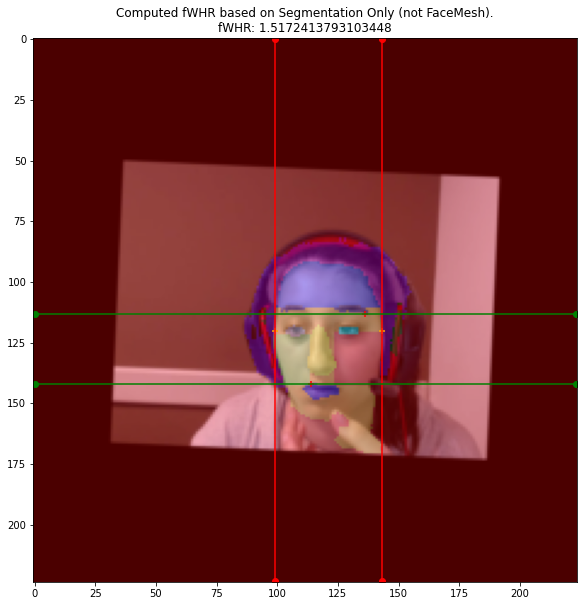

In [23]:
data = {
    'img': np.array(img.img),
    'sampling_strategy': 'use_all',
    'align_face': True,
    'num_attempts': 10
}
out = d.request(data=data,)

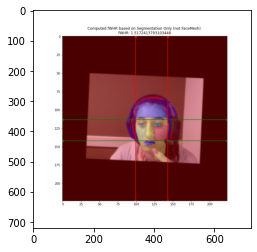

In [25]:
plt.imshow(out['img'])

In [26]:
out['row']

{'rgb_of_Background/undefined': (43, 39, 41),
 'rgb_of_Lips': (134, 86, 112),
 'rgb_of_Nose': (173, 138, 154),
 'rgb_of_Hair': (43, 31, 39),
 'rgb_of_Ears': (118, 10, 33),
 'rgb_of_Eyebrows': (120, 103, 117),
 'rgb_of_Teeth': None,
 'rgb_of_General face': (141, 119, 129),
 'rgb_of_Facial hair': None,
 'rgb_of_Specs/sunglasses': None,
 'rgb_of_right_eye': (79, 74, 92),
 'rgb_of_left_eye': (102, 89, 107),
 'rgb_of_left_cheek': (194, 162, 174),
 'rgb_of_right_cheek': (144, 121, 132),
 'rgb_of_forehead': (188, 158, 167),
 'img_rot_degrees': 2.601724630621069,
 'img_num_rotations': 4,
 'img_eye_slope': 0.0,
 'fwhr': 1.5172413793103448,
 'bizygoatic_w_px': 44.0,
 'upperfacial_h_px': 29.0,
 'tot_head_area_px': 3876,
 'pct_of_head_Lips': 0.01780185758513932,
 'pct_of_head_Nose': 0.04463364293085655,
 'pct_of_head_Hair': 0.30314757481940147,
 'pct_of_head_Ears': 0.0152218782249742,
 'pct_of_head_Eyebrows': 0.01393188854489164,
 'pct_of_head_Teeth': 0.0,
 'pct_of_head_General face': 0.2569659442

In [51]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.


## Package up this library and ship it in `depdir/libraries/`
Need to find an example of one of these libraries that you can bundle up and make our library look like that, then copy it into the libraries directory for shipping.

The UbiOps docs around what actually goes in the libraries directory is pretty unclear.  I will just try some stuff and ask Anouk if I have trouble.

My first attempt will be to package up the entire directory, delete the deployment package itself.

In [52]:
!pwd

/home/fortville/code/prod-mod-face-profile/nbs


In [62]:
!cp -r .. ../../prod-mod-face-profile-cp
!rm -rf ../../prod-mod-face-profile-cp/deployment_package/
!rm -rf ../deployment_package/libraries
!mkdir ../deployment_package/libraries
!mv ../../prod-mod-face-profile-cp ../deployment_package/libraries/prod-mod-face-profile

### Adding the deployment package to the gitignore
We can always reproduce the deployment package from the notebook.  That's the whole point.

In [63]:
!echo 'deployment_package' >> ../.gitignore

## Adding `prcvd` (proprietary code) to `deployment_package/libraries`
Need to add `prcvd` to libraries because it's private for now.
Instead of using the local copy, we will clone prcvd into our project directory here and use that one.

In [66]:
!git clone 

/home/fortville/code/prod-mod-face-profile/nbs
